In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load libraries
import numpy as np 
import pandas as pd 
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from numpy.random import randint
from random import random as rnd
from random import gauss, randrange
import re
import scipy.stats as st
import pathlib
import os
import os.path
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from networkx import *
from sklearn import preprocessing
import matplotlib


In [3]:
! pip install pandas_montecarlo --upgrade --no-cache-dir

  Created wheel for pandas-montecarlo: filename=pandas_montecarlo-0.0.2-cp36-none-any.whl size=7553 sha256=af8d39b160117b73e6d475a62ef794c73539cc2ff80bae91471449f061a614db
  Stored in directory: /tmp/pip-ephem-wheel-cache-s5m91jgq/wheels/8c/29/44/622bf8ea542ec73a0901a765b9102dd49f9e1076be3efc5411
Successfully built pandas-montecarlo


In [0]:
import pandas_montecarlo

IMPORTAZIONE DEI DATASET

In [0]:
URL ='/content/drive/My Drive/flights.csv' 
#URL ="flights.csv"
airline_url = "/content/drive/My Drive/airlines.csv"
#airline_url = "airlines.csv"
airports_url = "/content/drive/My Drive/airports.csv"
#airports_url ="airports.csv"

In [6]:
# load the dataset
df = pd.read_csv(URL, sep = ",") 
airlines_names = pd.read_csv(airline_url, sep = ",")
airports = pd.read_csv(airports_url, sep = ",")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


PREPROCESSING

In [0]:
df['flight_route'] = list(zip(df.ORIGIN_AIRPORT, df.DESTINATION_AIRPORT ))      # Uniamo in una lista le Origini e le Destinazioni per ottenere le singole Route
df = df[df['ORIGIN_AIRPORT'].fillna(0).str.contains(r'^[a-zA-Z]+$', na=False)]  # Nella colonna Origin Airport abbiamo eliminato quei valori numerici in quanto non rappresentanti nessuna origine, in quanto dubbia natura
list_flight = list(set(df['flight_route']))                                     # list_flight avrà tutte le rotte inserite in una lista di tuple

In [0]:
df['flight_route'] = df['flight_route'].astype(str)                             # converte tutte le flight_route a tipo Stringa, avremo una Serie                                                      

In [0]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])                        # Vengono unite in un'unica colonna DATE le colonne YEAR,MONTH E DAY

In [0]:
X = df.groupby(['flight_route']).ARRIVAL_DELAY.apply(lambda x: pd.Series([(x < 0).sum(), (x >= 0).sum()])).unstack()    # Raggruppiamo per Flight_Route e controlliamo che le rotte siano in Orario(0) o in Ritardo(1)

In [0]:
number_delay_airport = X
number_delay_airport.rename(columns = {0: 'Number_on_time', 1 :'Number_delay'}, inplace= True)
number_delay_airport['Percentage_delay'] = number_delay_airport['Number_delay'] / (number_delay_airport['Number_delay'] + number_delay_airport['Number_on_time'])    # Calcoliamo la percentuale di ritardi 
number_delay_airport.reset_index(inplace=True)

Aggiungiamo la distanza associata al Flight_Route

In [0]:
df_reducted = df[['flight_route','DISTANCE']]         # Aggiungiamo la colonna DISTANCE al nostro DataFrame
number_delay_airport = pd.merge(number_delay_airport,df_reducted, how='inner', right_on='flight_route', left_on='flight_route' )    # Facciamo Inner Join su flight_route e prendiamo la Colonna Distance
number_delay_airport.drop_duplicates(subset= ['flight_route', 'Percentage_delay'], inplace=True)   # droppiamo i valori dupplicati
number_delay_airport.reset_index(inplace=True, drop = True)  # Resettiamo l'indice

Standardizzare percentuale ritardo e distanza

In [13]:
number_delay_airport.head(2)

,flight_route,Number_on_time,Number_delay,Percentage_delay,DISTANCE
0,"('ABE', 'ATL')",572,314,0.354402,692
1,"('ABE', 'DTW')",411,284,0.408633,425


ABBIAMO STANDARDIZZATO I VALORI DISTANCE E LA PERCENTUALE DEI RITARDI, RISPETTO AI VALORI MINIMI E MASSIMI.


In [0]:
def standardizer(df):
  x = []
  for Percentage_delay, DISTANCE in zip(df.Percentage_delay, df.DISTANCE):
    to_append = list([Percentage_delay])
    to_append.extend([DISTANCE])
    x.append(to_append)
    min_val_Percentage_delay = df['Percentage_delay'].min()
    max_val_Percentage_delay = df['Percentage_delay'].max()
    min_val_DISTANCE = df['DISTANCE'].min()
    max_val_DISTANCE = df['DISTANCE'].max()

    func = lambda x, min_x, max_x: (x - min_x) / (max_x - min_x)

    # restituisce lista standardizzata dove il primo è delay il secondo è DISTANCE
    x_2 = [[func(var1, min_val_Percentage_delay, max_val_Percentage_delay), func(var2, min_val_DISTANCE, max_val_DISTANCE)] for var1, var2 in x ]
    df_to_attach = pd.DataFrame.from_records(x_2)
    df_to_attach.rename(columns = {0: 'Percentage_delay_std', 1 :'DISTANCE_std'}, inplace= True) # cambia nome colonne
    df.reset_index(inplace=True, drop=True)
    df_to_attach.reset_index(inplace=True, drop=True)

    number_delay_airport = pd.concat([df, df_to_attach], axis=1) # concatena i due df

    number_delay_airport.loc[:, 'Percentage_delay_std'] = 1-number_delay_airport.loc[:, 'Percentage_delay_std'] 
    number_delay_airport.loc[:, 'DISTANCE_std'] = 1- number_delay_airport.loc[:, 'DISTANCE_std'] 

  return number_delay_airport



In [0]:
number_delay_airport = standardizer(number_delay_airport)

Fine del **PREPROCESSING**


Usare Dijkstra per scegliere i percorsi possibili (individui)

In [0]:
flights = df   

In [0]:
flights= flights.drop(columns = ['YEAR', 'MONTH', 'DAY'])  # eliminiamo le colonne YEAR,MONTH E DAY

CREIAMO NODI E ARCHI PER IL GRAFO RELATIVO ALLE ROUTE

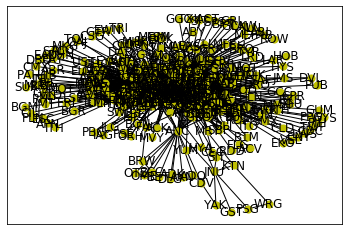

In [18]:
FG = nx.from_pandas_edgelist(flights, source='ORIGIN_AIRPORT', target='DESTINATION_AIRPORT', edge_attr=True,)   
FG.nodes()
FG.edges()
nx.draw_networkx(FG, with_labels=True,node_size=50, node_color='y') # Vista rapida del grafico

ORA TROVIAMO TUTTI I PERCORSI DISPONIBILI.

IN SOURCE METTEREMO UNA PARTENZA, IN TARGET UNA DESTINAZIONE.

CUTOFF: è IL NUMERO DI TRATTE MASSIME CHE VOGLIAMO RAPPRESENTARE.

In [0]:
list_path = []
for path in nx.all_simple_paths(FG, source='GUM', target='CLD', cutoff=4):
    list_path.append(path)

DOPO AVER CREATO TUTTI I PERCORSI,LI INSERIAMO IN UNA COLONNA DEL DATAFRAME 'List_Path' LA COLONNA 'PATH'



In [0]:
list_path = pd.DataFrame({'Path': list_path})

CREIAMO TUTTI I POSSIBILI PERCORSI DALLA PARTENZA ALLA DESTINAZIONE SCELTE

In [0]:
def route_creator(df,column):

  series = df[str(column)]
  
  couples = lambda ls: [(x,y) for x,y in zip(ls[:-1], ls[1:])]
  
  df['individuals'] = series.apply(couples)
  
  return df

LA COLONNA 'INDIVIDUALS' VIENE AGGIUNTA AL DATAFRAME 'List_Path'

In [0]:
list_path = route_creator(list_path, 'Path')

ADESSO AGGIUNGIAMO AL DATAFRAME UNA COLONNA CON UNA LISTA DELLE DISTANZE, DOVE OGNI DISTANZA CORRISPONDE POSIZIONALMENTE A FLIGHT_ROUTE E POI FACCIAMO LA STESSA COSA CON I RITARDI

In [0]:
number_delay_airport["Percentage_delay_std"] = number_delay_airport["Percentage_delay_std"].fillna(0)

CREIAMO LA FUNZIONE LIST_DELAY_CREATOR E LIST_DISTANCE_CREATOR E CALCOLIAMO LA PERCENTUALE DEI RITARDI STANDARDIZZATI E LA DISTANZA STANDARDIZZATA SU TUTTE LE ROTTE

In [0]:
def list_delay_creator(df):
  external_list = []
  for ind in df["individuals"]: #per ogni riga della colonna dove ci stanno gli individui della nostra popolazione
    inner_list = []

    for route in ind: # per ogni valore dentro ogni individuo
      for flight_route in number_delay_airport['flight_route']:
        
        if str(flight_route)==str(route):
           corresponding_perc = number_delay_airport.loc[number_delay_airport['flight_route'] == flight_route, 'Percentage_delay_std'].iloc[0]
           inner_list.append(corresponding_perc)
    external_list.append(inner_list)
  
  return external_list

In [0]:
def list_distance_creator(df):
  external_list = []
  for ind in df["individuals"]: #per ogni riga della colonna dove ci stanno gli individui della nostra popolazione
    inner_list = []

    for route in ind: # per ogni valore dentro ogni individuo
      for flight_route in number_delay_airport['flight_route']:
        
        if str(flight_route)==str(route):
           corresponding_perc = number_delay_airport.loc[number_delay_airport['flight_route'] == flight_route, 'DISTANCE_std'].iloc[0]
           inner_list.append(corresponding_perc)
    external_list.append(inner_list)
  
  return external_list

DOPO AVER CALCOLATO I RITARDI STANDARDIZZATI E LE DISTANZE STANDARDIZZATE LE INSERIAMO NEL DATAFRAME

In [0]:
#creo df di delay std e lo aggiungo a list_path
def Path_delay_std(df):
  list_with_delay_for_each_individual = list_delay_creator(df)
  df_with_delay_for_each_individual = pd.DataFrame({'Path_delay_std': list_with_delay_for_each_individual})
  df = pd.concat([df, df_with_delay_for_each_individual], axis = 1)
  df.reset_index(drop=True, inplace=True)
  return df

In [27]:
list_path = Path_delay_std(list_path)
list_path.head()

,Path,individuals,Path_delay_std
0,"[GUM, HNL, LAS, LAX, CLD]","[(GUM, HNL), (HNL, LAS), (LAS, LAX), (LAX, CLD)]","[0.5679758308157099, 0.626387176325524, 0.4609..."
1,"[GUM, HNL, ITO, LAX, CLD]","[(GUM, HNL), (HNL, ITO), (ITO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5516088591725867, 0.691..."
2,"[GUM, HNL, KOA, LAX, CLD]","[(GUM, HNL), (HNL, KOA), (KOA, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5968020065841041, 0.669..."
3,"[GUM, HNL, OGG, LAX, CLD]","[(GUM, HNL), (HNL, OGG), (OGG, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5543293718166384, 0.657..."
4,"[GUM, HNL, LIH, LAX, CLD]","[(GUM, HNL), (HNL, LIH), (LIH, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5993162393162393, 0.742..."


In [0]:
#creo df di distance std e lo aggiungo a list_path
def Path_distance_std(df):
  list_with_distance_for_each_individual = list_distance_creator(df)
  df_with_distance_for_each_individual = pd.DataFrame({'Path_distance_std': list_with_distance_for_each_individual})
  df = pd.concat([df, df_with_distance_for_each_individual], axis = 1)
  df.reset_index(drop=True, inplace=True)
  return df

In [29]:
list_path = Path_distance_std(list_path)
list_path.head()

,Path,individuals,Path_delay_std,Path_distance_std
0,"[GUM, HNL, LAS, LAX, CLD]","[(GUM, HNL), (HNL, LAS), (LAS, LAX), (LAX, CLD)]","[0.5679758308157099, 0.626387176325524, 0.4609...","[0.23821039903264818, 0.4476017734784361, 0.95..."
1,"[GUM, HNL, ITO, LAX, CLD]","[(GUM, HNL), (HNL, ITO), (ITO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5516088591725867, 0.691...","[0.23821039903264818, 0.9607013301088271, 0.51..."
2,"[GUM, HNL, KOA, LAX, CLD]","[(GUM, HNL), (HNL, KOA), (KOA, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5968020065841041, 0.669...","[0.23821039903264818, 0.9713825070536074, 0.49..."
3,"[GUM, HNL, OGG, LAX, CLD]","[(GUM, HNL), (HNL, OGG), (OGG, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5543293718166384, 0.657...","[0.23821039903264818, 0.9840790004030633, 0.50..."
4,"[GUM, HNL, LIH, LAX, CLD]","[(GUM, HNL), (HNL, LIH), (LIH, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5993162393162393, 0.742...","[0.23821039903264818, 0.9836759371221282, 0.47..."


UTILIZZANDO MONTECARLO SIMULIAMO LA DISTRIBUZIONE DEI RITARDI CON N ITERAZIONI PER RICAVARNE LA DEVIAZIONE STANDARD E INSERIAMO QUESTI VALORI NELLA COLONNA 'DELAY_SERIES'

In [0]:
def Delay_creator_with_MonteCarlo(df,column):
  delay_serie = pd.Series()
  for delay_of_ind in df[str(column)]:
    delay_of_ind_2 = pd.Series(delay_of_ind) # trasforma riga in serie
    delay_of_ind_3 = delay_of_ind_2.transpose() # serie in colonna 
    mc = delay_of_ind_3.montecarlo(sims=1000)    # .montecarlo è una libreria Python
    stats = mc.stats
    stats_std = stats['max'] #prendo il massimo dei ritardi
    stats_std = pd.Series([stats_std]) #lo metto in una serie di lista per motivi computazionali
    delay_serie = delay_serie.append(stats_std,ignore_index=True)
    delay_df = pd.DataFrame(delay_serie)
    delay_df = delay_df.rename(columns={0: "Delay_Series"}) 
    df1 = pd.concat([df, delay_df], axis=1) 
  return df1

In [31]:
list_path = Delay_creator_with_MonteCarlo(list_path,'Path_delay_std')
list_path

,Path,individuals,Path_delay_std,Path_distance_std,Delay_Series
0,"[GUM, HNL, LAS, LAX, CLD]","[(GUM, HNL), (HNL, LAS), (LAS, LAX), (LAX, CLD)]","[0.5679758308157099, 0.626387176325524, 0.4609...","[0.23821039903264818, 0.4476017734784361, 0.95...",2.291134
1,"[GUM, HNL, ITO, LAX, CLD]","[(GUM, HNL), (HNL, ITO), (ITO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5516088591725867, 0.691...","[0.23821039903264818, 0.9607013301088271, 0.51...",2.446774
2,"[GUM, HNL, KOA, LAX, CLD]","[(GUM, HNL), (HNL, KOA), (KOA, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5968020065841041, 0.669...","[0.23821039903264818, 0.9713825070536074, 0.49...",2.469910
3,"[GUM, HNL, OGG, LAX, CLD]","[(GUM, HNL), (HNL, OGG), (OGG, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5543293718166384, 0.657...","[0.23821039903264818, 0.9840790004030633, 0.50...",2.415433
4,"[GUM, HNL, LIH, LAX, CLD]","[(GUM, HNL), (HNL, LIH), (LIH, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5993162393162393, 0.742...","[0.23821039903264818, 0.9836759371221282, 0.47...",2.545688
5,"[GUM, HNL, LAX, CLD]","[(GUM, HNL), (HNL, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6834712334038868, 0.635...","[0.23821039903264818, 0.48911729141475213, 0.9...",1.887230
6,"[GUM, HNL, PDX, LAX, CLD]","[(GUM, HNL), (HNL, PDX), (PDX, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5918653576437587, 0.626...","[0.23821039903264818, 0.4796453043127771, 0.83...",2.422266
7,"[GUM, HNL, SFO, LAX, CLD]","[(GUM, HNL), (HNL, SFO), (SFO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6486220472440944, 0.494...","[0.23821039903264818, 0.5209592906086256, 0.93...",2.346560
8,"[GUM, HNL, PHX, LAX, CLD]","[(GUM, HNL), (HNL, PHX), (PHX, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5901785714285714, 0.504...","[0.23821039903264818, 0.4163643692059653, 0.92...",2.298317
9,"[GUM, HNL, SEA, LAX, CLD]","[(GUM, HNL), (HNL, SEA), (SEA, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5755478662053056, 0.553...","[0.23821039903264818, 0.4647319629181782, 0.81...",2.332781


Ordino a seconda della varianza calcolcata con montecarlo

In [0]:
def Average(lst): 
    return sum(lst) / len(lst) 

STANDARDIZZIAMO LA DELAY_SERIES IN MODO CHE POSSIAMO SOMMARE I VALORI CON LA PATH_DISTANCE_STD

In [0]:
from sklearn.preprocessing import MinMaxScaler
def standardizer_mcdelay_distance(df, column ):
  X = df.Delay_Series
  X = X.to_frame()
  scaler = preprocessing.MinMaxScaler()
  scaled_df = scaler.fit_transform(X)
  new_column = pd.DataFrame(scaled_df, columns=['Delay_Series'])
  new_column.loc[:,'Delay_Series'] = 1- new_column.loc[:,'Delay_Series']
  df = pd.concat([new_column, df], axis=1)
  return df

In [34]:
list_path['Delay_Series']= standardizer_mcdelay_distance(list_path, 'Delay_Series')
list_path.head()


,Path,individuals,Path_delay_std,Path_distance_std,Delay_Series
0,"[GUM, HNL, LAS, LAX, CLD]","[(GUM, HNL), (HNL, LAS), (LAS, LAX), (LAX, CLD)]","[0.5679758308157099, 0.626387176325524, 0.4609...","[0.23821039903264818, 0.4476017734784361, 0.95...",0.532702
1,"[GUM, HNL, ITO, LAX, CLD]","[(GUM, HNL), (HNL, ITO), (ITO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5516088591725867, 0.691...","[0.23821039903264818, 0.9607013301088271, 0.51...",0.352635
2,"[GUM, HNL, KOA, LAX, CLD]","[(GUM, HNL), (HNL, KOA), (KOA, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5968020065841041, 0.669...","[0.23821039903264818, 0.9713825070536074, 0.49...",0.325868
3,"[GUM, HNL, OGG, LAX, CLD]","[(GUM, HNL), (HNL, OGG), (OGG, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5543293718166384, 0.657...","[0.23821039903264818, 0.9840790004030633, 0.50...",0.388894
4,"[GUM, HNL, LIH, LAX, CLD]","[(GUM, HNL), (HNL, LIH), (LIH, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5993162393162393, 0.742...","[0.23821039903264818, 0.9836759371221282, 0.47...",0.238197


PER CALCOLARE LA FITNESS VALUE SOMMIAMO "Delay_Series" E LA MEDIA "Path_distance_std"

In [0]:
def fitness_function(df, colonna1, colonna2):
  list_of_fitness_value = []
  for i, j in zip(df[str(colonna1)], df[str(colonna2)]):
    x = i + Average(j)
    list_of_fitness_value.append(x)
  series_of_fitness_value = pd.Series(list_of_fitness_value)
  df['fitness_values'] = series_of_fitness_value.values
  return df

In [0]:
list_path = fitness_function(list_path, "Delay_Series", "Path_distance_std")

FUNZIONI CHE SORTIAMO IN MODO CRESCENTE E DECRESCENTE

In [0]:
def dataframe_sorter(df, colonna):
  df = df.sort_values([str(colonna)], ascending=True)
  return df

In [0]:
def dataframe_sorter_desc(df, colonna):
  df = df.sort_values([str(colonna)], ascending=False)
  return df

In [39]:
list_path = dataframe_sorter_desc(list_path, "fitness_values")
list_path.head()

,Path,individuals,Path_delay_std,Path_distance_std,Delay_Series,fitness_values
5,"[GUM, HNL, LAX, CLD]","[(GUM, HNL), (HNL, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6834712334038868, 0.635...","[0.23821039903264818, 0.48911729141475213, 0.9...",1,1.571409
15,"[GUM, HNL, SMF, LAX, CLD]","[(GUM, HNL), (HNL, SMF), (SMF, LAX), (LAX, CLD)]","[0.5679758308157099, 0.4186746987951807, 0.450...","[0.23821039903264818, 0.5080612656187021, 0.92...",0.785202,1.450760
16,"[GUM, HNL, SJC, LAX, CLD]","[(GUM, HNL), (HNL, SJC), (SJC, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5595667870036101, 0.407...","[0.23821039903264818, 0.517130189439742, 0.942...",0.671344,1.342444
14,"[GUM, HNL, IAH, LAX, CLD]","[(GUM, HNL), (HNL, IAH), (IAH, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5091463414634146, 0.420...","[0.23821039903264818, 0.21745264006449017, 0.7...",0.714701,1.256922
12,"[GUM, HNL, OAK, LAX, CLD]","[(GUM, HNL), (HNL, OAK), (OAK, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6339113680154143, 0.407...","[0.23821039903264818, 0.5187424425634825, 0.93...",0.585422,1.255464


CREARE LA COLONNA PROBABILITà, CONTENTENTE IL VALORE NORMALIZZATO DELLA FITNESS VALUE



In [0]:
def probability(df):
  df['zscore'] = (df.fitness_values - df.fitness_values.mean())/df.fitness_values.std(ddof=0)
  df['Probability'] = st.norm.cdf(df.zscore)
  df.drop(['zscore'], axis=1, inplace=True)
  return df

In [0]:
list_path = probability(list_path)

MAX_VALUE_CONSTANT MI RESTITUISCE IL VALORE DI FITNESS VALUE PIù ALTA

In [42]:
max_value_constant = list_path["fitness_values"].loc[list_path["fitness_values"].idxmax()]
max_value_constant

1.5714093779390033

CREIAMO UNA FUNZIONE CON TUTTE LE POSSIBILI FUNZIONI DI SELEZIONE DI PROBABILITà, PER RENDERE CASUALE L'ORDINAMENTO



In [0]:
#DataFrame.sample(self, n=None, frac=None, replace=False, weights=None, random_state=None, axis=None)
def select_ind_probabilities(df, column_name, mode, n):
  if mode == "weighted":
    df = df.sample(n= n, frac=None, replace=False, weights=df[str(column_name)],axis=0)
  if mode == "random":
    df = df.sample(n= n, replace=False)
  if mode == "besthalf":
    df =  df.sort_values([str(column_name)], ascending=False)
    half_df_len = int(len(df)/ 2) 
    df =  df.iloc[:, :half_df_len]
  df.reset_index(drop=True, inplace=True)
  return df

In [44]:
selected = select_ind_probabilities(list_path, "Probability", "random", 6)
selected

,Path,individuals,Path_delay_std,Path_distance_std,Delay_Series,fitness_values,Probability
0,"[GUM, HNL, SFO, LAX, CLD]","[(GUM, HNL), (HNL, SFO), (SFO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6486220472440944, 0.494...","[0.23821039903264818, 0.5209592906086256, 0.93...",0.468578,1.139174,0.685380
1,"[GUM, HNL, ANC, LAX, CLD]","[(GUM, HNL), (HNL, ANC), (ANC, LAX), (LAX, CLD)]","[0.5679758308157099, 0.7709090909090909, 0.776...","[0.23821039903264818, 0.4445787988714228, 0.53...",0,0.550333,0.026614
2,"[GUM, HNL, SMF, LAX, CLD]","[(GUM, HNL), (HNL, SMF), (SMF, LAX), (LAX, CLD)]","[0.5679758308157099, 0.4186746987951807, 0.450...","[0.23821039903264818, 0.5080612656187021, 0.92...",0.785202,1.450760,0.960893
3,"[GUM, HNL, PDX, LAX, CLD]","[(GUM, HNL), (HNL, PDX), (PDX, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5918653576437587, 0.626...","[0.23821039903264818, 0.4796453043127771, 0.83...",0.380989,1.016217,0.491358
4,"[GUM, HNL, SLC, LAX, CLD]","[(GUM, HNL), (HNL, SLC), (SLC, LAX), (LAX, CLD)]","[0.5679758308157099, 0.8637770897832817, 0.550...","[0.23821039903264818, 0.4008464328899637, 0.88...",0.154464,0.782286,0.163193
5,"[GUM, HNL, LAS, LAX, CLD]","[(GUM, HNL), (HNL, LAS), (LAS, LAX), (LAX, CLD)]","[0.5679758308157099, 0.626387176325524, 0.4609...","[0.23821039903264818, 0.4476017734784361, 0.95...",0.532702,1.190048,0.755380


EFFETUIAMO LA MUTATION DELLE ROTTE, OVVERO MUTIAMO IN MODO RANDOMICO UN CROMOSOMA CON UN ALTRO NELLO STESSO INDIVIDUO

In [0]:
def swapPositions(lista, pos1, pos2): 
    lista[pos1], lista[pos2] = lista[pos2], lista[pos1] 
    return lista

In [0]:
def mutation(df):
  for row in df.iterrows():
      if (len(row[1][0]) > 3):
          list_index = list(range(1, len(row[1][0]) - 1))
          pos1 = random.choice(list_index)
          list_index.remove(pos1)
          pos2 = random.choice(list_index)
          list_swapped = swapPositions(row[1][0], pos1, pos2)
  return df

CROSSOVER: FACCIAMO LO SWAPPING TRA CROMOSOMI DI INDIVIDUI DIVERSI(INCROCIANDOLI)

In [0]:
def crossover(df):
  out = df['Path'].apply(lambda x : pd.Series(x))
  dfLength = len(out)
  if dfLength%2==0:
    oddIndex = list(range(0,dfLength-1, 2))
    evenIndex = list(range(1, dfLength,2))
  else:
    oddIndex = list(range(0,dfLength, 2))
    evenIndex = list(range(1, dfLength,2))

  #Swapping delle righe pari-dispari
  oddData = out.iloc[oddIndex][[1,2]].copy() 
  evenData = out.iloc[evenIndex][[1,2]].copy()

  out.iloc[oddIndex, [1,2]] = evenData.values
  out.iloc[evenIndex, [1,2]] = oddData.values

  #Swapping colonne 2 e 3
  col2 = out.loc[:,1].copy()
  col3 = out.loc[:,2].copy()

  out.loc[:,1] = col3.values
  out.loc[:,2] = col2.values

  df = out.apply(lambda x : list(x.dropna().values), axis = 1)

  return df

In [48]:
df = crossover(selected)
df = df.to_frame()
df= df.rename(columns={0:'Path'})
df

,Path
0,"[GUM, ANC, HNL, LAX, CLD]"
1,"[GUM, SFO, HNL, LAX, CLD]"
2,"[GUM, PDX, HNL, LAX, CLD]"
3,"[GUM, SMF, HNL, LAX, CLD]"
4,"[GUM, LAS, HNL, LAX, CLD]"
5,"[GUM, SLC, HNL, LAX, CLD]"


GENETIC ALGORITHM

ORA PRENDIAMO IN CONSIDERAZIONE IL DATAFRAME NUOVO DATAFRAME RISULTATO DELLE OPERAZIONI PRECEDENTI. SU DI ESSO VERRANNO ITERATE LE STESSE FUNZIONI N VOLTE ALLO SCOPO DI RICAVARE LA FITNESS VALUE MIGLIORE.

IL DATAFRAME SARà COMPOSTO DAGLI INDIVIDUI, PATH_DISTANCE_STD, PATH_DELAT_STD E LE FITNESS VALUE MIGLIORI PER LE VARIE ROTTE

In [49]:
#iterate fitness function
elite = pd.DataFrame()
df_generale = list_path
F,Q = [],[] #liste che servono per le visualizzazioni
lista_valori_max, lista_indici_max = [],[]
for i in range(500):
  selection= select_ind_probabilities(list_path, "Probability", "weighted", 10) #per n volte prende da list_path 10 righe
  selection_path = selection.Path 
  selection_path = selection_path.to_frame() 
  selection_path.rename(columns={0:'Path'}, inplace=True)
  selection_path = mutation(selection_path) #mutation
  selection_path = crossover(selection_path) #crossover
  selection_path = selection_path.to_frame()
  selection_path = selection_path.rename(columns={0:'Path'})
  selection_path = selection_path.Path.apply(lambda x: list(pd.unique(x)))
  selection_path = selection_path.to_frame()
  selection_path = selection_path.rename(columns={0:'Path'})
  selection_path = route_creator(selection_path,'Path')   # dalla lista degli aeroporti ricreami le route
  selection_path = Path_delay_std(selection_path) #crea il ritardo
  selection_path = Path_distance_std(selection_path) #crea la distanza
  selection_path = Delay_creator_with_MonteCarlo(selection_path,'Path_delay_std') #crea colonna delay
  selection_path = fitness_function(selection_path, "Delay_Series", "Path_distance_std")
  selection_path = dataframe_sorter_desc(selection_path, "fitness_values")
  for  index, row  in selection_path.iterrows():
    if (len(row[1]) != len(row[2])):
      selection_path.drop(index, inplace=True)
  if selection_path["fitness_values"].empty == True:
    lista_valori_max.append(0)
    lista_indici_max.append(i)
  else:
    lista_valori_max.append(selection_path["fitness_values"].loc[selection_path["fitness_values"].idxmax()])
    lista_indici_max.append(i)
  selection_path_to_append = selection_path.head(5)
  df_generale = df_generale.append(selection_path_to_append, ignore_index=True)
  df_generale = df_generale.drop_duplicates(subset='fitness_values', keep='last')
  max_value = df_generale["fitness_values"].loc[df_generale["fitness_values"].idxmax()]
  Q.append(i)
  F.append(max_value)
  print("gen n ",i)
df_generale = dataframe_sorter_desc(df_generale, "fitness_values")
df_generale[['individuals','Path_delay_std', 'Path_distance_std','fitness_values']].head(10)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


gen n  0
gen n  1
gen n  2
gen n  3
gen n  4
gen n  5
gen n  6
gen n  7
gen n  8
gen n  9
gen n  10
gen n  11
gen n  12
gen n  13
gen n  14
gen n  15
gen n  16
gen n  17
gen n  18
gen n  19
gen n  20
gen n  21
gen n  22
gen n  23
gen n  24
gen n  25
gen n  26
gen n  27
gen n  28
gen n  29
gen n  30
gen n  31
gen n  32
gen n  33
gen n  34
gen n  35
gen n  36
gen n  37
gen n  38
gen n  39
gen n  40
gen n  41
gen n  42
gen n  43
gen n  44
gen n  45
gen n  46
gen n  47
gen n  48
gen n  49
gen n  50
gen n  51
gen n  52
gen n  53
gen n  54
gen n  55
gen n  56
gen n  57
gen n  58
gen n  59
gen n  60
gen n  61
gen n  62
gen n  63
gen n  64
gen n  65
gen n  66
gen n  67
gen n  68
gen n  69
gen n  70
gen n  71
gen n  72
gen n  73
gen n  74
gen n  75
gen n  76
gen n  77
gen n  78
gen n  79
gen n  80
gen n  81
gen n  82
gen n  83
gen n  84
gen n  85
gen n  86
gen n  87
gen n  88
gen n  89
gen n  90
gen n  91
gen n  92
gen n  93
gen n  94
gen n  95
gen n  96
gen n  97
gen n  98
gen n  99
gen n  100

,individuals,Path_delay_std,Path_distance_std,fitness_values
25,"[(GUM, HNL), (HNL, SLC), (SLC, LAX), (LAX, CLD)]","[0.5679758308157099, 0.8637770897832817, 0.550...","[0.23821039903264818, 0.4008464328899637, 0.88...",3.245882
35,"[(GUM, HNL), (HNL, LIH), (LIH, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5993162393162393, 0.742...","[0.23821039903264818, 0.9836759371221282, 0.47...",3.217191
38,"[(GUM, HNL), (HNL, MSP), (MSP, LAX), (LAX, CLD)]","[0.5679758308157099, 0.8444444444444444, 0.585...","[0.23821039903264818, 0.20374848851269645, 0.6...",3.164179
36,"[(GUM, HNL), (HNL, KOA), (KOA, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5968020065841041, 0.669...","[0.23821039903264818, 0.9713825070536074, 0.49...",3.143932
39,"[(GUM, HNL), (HNL, ITO), (ITO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5516088591725867, 0.691...","[0.23821039903264818, 0.9607013301088271, 0.51...",3.120897
32,"[(GUM, HNL), (HNL, OGG), (OGG, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5543293718166384, 0.657...","[0.23821039903264818, 0.9840790004030633, 0.50...",3.093537
43,"[(GUM, HNL), (HNL, PDX), (PDX, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5918653576437587, 0.626...","[0.23821039903264818, 0.4796453043127771, 0.83...",3.057494
27,"[(GUM, HNL), (HNL, SAN), (SAN, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6151419558359621, 0.566...","[0.23821039903264818, 0.47742845626763397, 0.9...",3.056526
31,"[(GUM, HNL), (HNL, SFO), (SFO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6486220472440944, 0.494...","[0.23821039903264818, 0.5209592906086256, 0.93...",3.017156
33,"[(GUM, HNL), (HNL, DFW), (DFW, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6666666666666667, 0.581...","[0.23821039903264818, 0.24163643692059655, 0.7...",3.007446


In [50]:
df_generale[['individuals','Path_delay_std', 'Path_distance_std','fitness_values']].head(20)

,individuals,Path_delay_std,Path_distance_std,fitness_values
25,"[(GUM, HNL), (HNL, SLC), (SLC, LAX), (LAX, CLD)]","[0.5679758308157099, 0.8637770897832817, 0.550...","[0.23821039903264818, 0.4008464328899637, 0.88...",3.245882
35,"[(GUM, HNL), (HNL, LIH), (LIH, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5993162393162393, 0.742...","[0.23821039903264818, 0.9836759371221282, 0.47...",3.217191
38,"[(GUM, HNL), (HNL, MSP), (MSP, LAX), (LAX, CLD)]","[0.5679758308157099, 0.8444444444444444, 0.585...","[0.23821039903264818, 0.20374848851269645, 0.6...",3.164179
36,"[(GUM, HNL), (HNL, KOA), (KOA, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5968020065841041, 0.669...","[0.23821039903264818, 0.9713825070536074, 0.49...",3.143932
39,"[(GUM, HNL), (HNL, ITO), (ITO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5516088591725867, 0.691...","[0.23821039903264818, 0.9607013301088271, 0.51...",3.120897
32,"[(GUM, HNL), (HNL, OGG), (OGG, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5543293718166384, 0.657...","[0.23821039903264818, 0.9840790004030633, 0.50...",3.093537
43,"[(GUM, HNL), (HNL, PDX), (PDX, LAX), (LAX, CLD)]","[0.5679758308157099, 0.5918653576437587, 0.626...","[0.23821039903264818, 0.4796453043127771, 0.83...",3.057494
27,"[(GUM, HNL), (HNL, SAN), (SAN, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6151419558359621, 0.566...","[0.23821039903264818, 0.47742845626763397, 0.9...",3.056526
31,"[(GUM, HNL), (HNL, SFO), (SFO, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6486220472440944, 0.494...","[0.23821039903264818, 0.5209592906086256, 0.93...",3.017156
33,"[(GUM, HNL), (HNL, DFW), (DFW, LAX), (LAX, CLD)]","[0.5679758308157099, 0.6666666666666667, 0.581...","[0.23821039903264818, 0.24163643692059655, 0.7...",3.007446


PLOTTA LE FITNESS VALUE MIGLIORI E L'ANDAMENTO



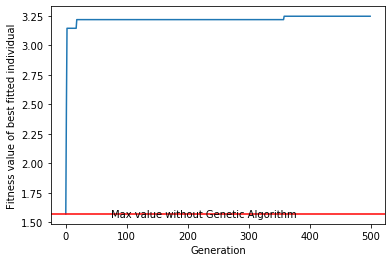

In [51]:
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.plot(Q,F)
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.ylabel('Fitness value of best fitted individual')
plt.xlabel('Generation')
plt.axhline(y=max_value_constant, color='r', linestyle='-')
plt.text(i/1.3, max_value_constant - ( max_value_constant*0.001) ,'Max value without Genetic Algorithm ', ha='right', va='center')
plt.show()

In [0]:
#lista_valori_max

VISUALIZZA IL VALORE MAX CHE IL GA TROVA AD OGNI ITERAZIONE (DOPO MUTATION E CROSSOVER)

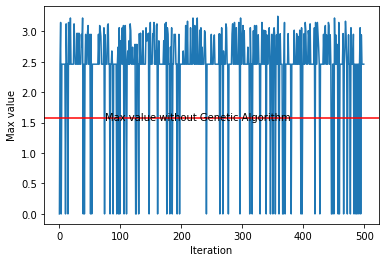

In [53]:
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.plot(lista_indici_max, lista_valori_max)
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.ylabel('Max value')
plt.xlabel('Iteration')
plt.axhline(y=max_value_constant, color='r', linestyle='-')
plt.text(i/1.3, max_value_constant + ( max_value_constant*0.01) ,'Max value without Genetic Algorithm ', ha='right', va='center')
plt.show()

In [0]:
lista_prova_indici_valori = lista_valori_max

In [55]:
print(lista_prova_indici_valori)

[0, 2.4586391897624336, 3.1439320958304817, 0, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 0, 3.120897024956096, 2.4586391897624336, 2.4586391897624336, 0, 3.1439320958304817, 2.4586391897624336, 2.4586391897624336, 3.2171909964952885, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 3.120897024956096, 2.8424011883028064, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 2.9680587295877645, 2.4586391897624336, 2.4586391897624336, 2.9680587295877645, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 2.948480081641291, 2.738446893265013, 3.2171909964952885, 0, 2.4586391897624336, 0, 2.4586391897624336, 2.948480081641291, 2.4586391897624336, 2.4586391897624336, 2.9680587295877645, 3.0935368022271974, 2.4586391897624336, 2.9156091787022875, 2.949516202537505, 0, 2.948480081641291, 0, 2.4586391897624336, 2.4586391897624336, 2.4586391897624336, 2.

In [0]:
lista_prova_indici_valori.sort() 

VISUALIZZA LA CLASSIFICA DEI VALORI MAX

Text(383.8461538461538, 1.5871234717183933, 'Max value without Genetic Algorithm ')

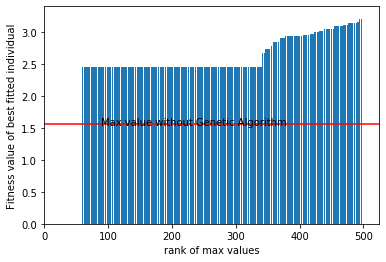

In [57]:
matplotlib.pyplot.bar(lista_indici_max, lista_prova_indici_valori)
plt.xlim(xmin=0)
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.ylabel('Fitness value of best fitted individual')
plt.xlabel('rank of max values')
plt.axhline(y=max_value_constant, color='r', linestyle='-')
plt.text(i/1.3, max_value_constant + ( max_value_constant*0.01) ,'Max value without Genetic Algorithm ', ha='right', va='center')
#plt.show()